[Reference](https://towardsdatascience.com/time-series-forecasting-with-dynamical-systems-methods-fa4afdf16fd0)

In [4]:
!pip install git+https://github.com/manu-mannattil/nolitsa.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/manu-mannattil/nolitsa.git to /tmp/pip-req-build-s4q95k0x
  Running command git clone -q https://github.com/manu-mannattil/nolitsa.git /tmp/pip-req-build-s4q95k0x
  Created wheel for nolitsa: filename=nolitsa-0.1-py3-none-any.whl size=31147 sha256=fef09c8a8c9edf913088c9e8e00650aebc49f87d77329a3e233053e53cff69b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-kxmjzryy/wheels/c5/46/b3/cca74fb43c32332828be5f61535e2bb6eba0164287dc4b9e15
Successfully built nolitsa


In [6]:
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.9 MB 4.7 MB/s 


In [10]:
!pip install giotto-tda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.3 MB/s 
     |████████████████████████████████| 458 kB 44.1 MB/s 
     |████████████████████████████████| 529 kB 50.3 MB/s 
     |████████████████████████████████| 3.1 MB 42.9 MB/s 
     |████████████████████████████████| 1.6 MB 70.0 MB/s 


In [12]:
!pip install openml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 119 kB 5.2 MB/s 
     |████████████████████████████████| 76 kB 557 kB/s 
  Created wheel for openml: filename=openml-0.12.2-py3-none-any.whl size=137326 sha256=8f94b0d6cf8064590fe90d54bd5295e35366d20012c6988742c329160979232f
  Stored in directory: /root/.cache/pip/wheels/6a/20/88/cf4ac86aa18e2cd647ed16ebe274a5dacee9d0075fa02af250
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=5794e19b6f0ce3f084e09e841e4632fb12abb97f6f99b958c8e2604c6aba5182
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built openml liac-arff


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nolitsa import dimension, delay
import plotly.express as px
import plotly.graph_objects as go
from sktime.datasets import load_airline, load_shampoo_sales, load_lynx
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from openml.datasets.functions import get_dataset

In [14]:
def takens(data, m=2, d=1):
    emb = np.array([data[0:len(data) - d*m]])
    for i in range(1, m):
        emb = np.append(emb, [data[i*d:len(data) - d*(m - i)]], axis=0)
        
    return emb.T

In [15]:
lorenz = get_dataset(42182).get_data(dataset_format='array')[0][0:, 0]
t = [i for i in range(len(lorenz))]
emb = takens(lorenz, m=3, d=5)
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=emb[:, 0], y=emb[:,1], z=emb[:, 2], mode='lines'
))
fig.show()

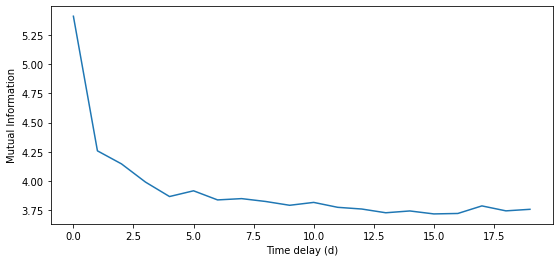

In [16]:
t = [i for i in np.arange(0, 20, 0.1)]
y = [np.sin(i) for i in t]
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (d)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(y, maxtau=20))

In [17]:
def find_optimal_delay(x, maxtau=50):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)
    return np.where(diffmi > 0)[0][0]

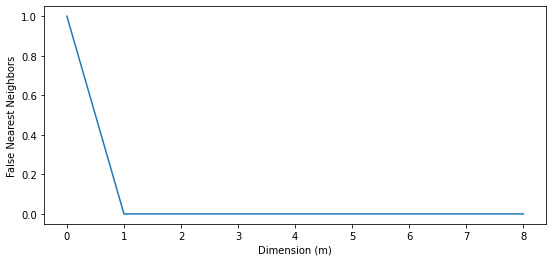

In [18]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(y, tau=4, dim=dim)
plt.figure(figsize=(9,4))
plt.xlabel('Dimension (m)')
plt.ylabel('False Nearest Neighbors')
plt.plot(f1)

In [19]:
def find_optional_dimension(x, tau, max_dim=10):
    dim = np.arange(1, max_dim)
    f1, f2, f3 = dimension.fnn(x, tau=tau, dim=dim)
    return np.where(f1 < 0.2)[0][0] + 1

In [20]:
def forecast_on_phase_space(y, m, d, forecast_horizon):
    emb = takens(y, m, d)
    
    # Divide into train and test
    X = emb[:, :m-1]
    y = emb[:, m-1]
    
    X_train = X[:len(X)-forecast_horizon, :]
    y_train = y[:len(y)-forecast_horizon]
    X_test = X[len(X)-forecast_horizon:, :]
    y_test = y[len(y)-forecast_horizon:]
    
    # Fit the regressor on the training data
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    
    # Predict the test data
    preds = rf.predict(X_test)
    
    print(f'R²: {r2_score(y_test, preds)}')
    print(f'RMSE: {mean_squared_error(y_test, preds, squared=False)}')
    
    # Plot the result
    preds_ = [np.nan for i in range(len(y)-forecast_horizon)] + list(preds)
    t = [i for i in range(len(y))]
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=t, y=y, mode='lines'
    ))
    fig.add_trace(go.Scatter(
        x=t, y=preds_, mode='lines', line=dict(color='red')))
    fig.show()

In [21]:
airline = load_airline()
forecast_on_phase_space(airline, 3, 1, 50)

R²: -0.022587240507686124
RMSE: 82.13382668547716
